In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_dir = '../data'
fn = f'{data_dir}/MWDD-export.csv'
df = pd.read_csv(fn)

C:\Users\masamune\AppData\Local\Temp\ipykernel_5828\3436584105.py:3: DtypeWarning: Columns (11,12,13,14,15,16,17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(fn)


Upon reading the .csv we get a warning about the photometry columns; if you look into it, it turns out some values are given in the .csv as something like `'     '`. We want to replace these with numeric NaNs and reset the dtype to float64.

In [3]:
filters = ['su', 'sg', 'sr', 'si', 'sz']
err_filters = [f'D{f}' for f in filters]

In [4]:
def replace_spaces(x):
    if isinstance(x, float):
        return x
    if x.strip():
        return x
    return np.nan

for f in filters:
    df[f] = df[f].apply(replace_spaces)

for f in err_filters:
    df[f] = df[f].apply(replace_spaces)

df[filters] = df[filters].astype(np.float64)
df[err_filters] = df[err_filters].astype(np.float64)

We also find that photometry is set to -9999.0 for some objects, which we can set to NaN as well.

In [5]:
for f in filters:
    df[f] = df[f].apply(lambda x: np.nan if x == -9999. else x)

Next we want to change the `'ismag'` ("is magnetic") column to binary.

In [6]:
df['ismag'] = df['ismag'].apply(lambda x: 1 if x == 'yes' else 0)
df['ismag'] = df['ismag'].astype(bool)

Next let's get an idea of the NaNs we have in the data.

In [7]:
N = len(df)
print(f'Total: {N}')

df.isna().sum()

Total: 44308


wdid            0
icrsra         34
icrsdec        34
spectype        0
teff         9260
logg         9334
mass        11541
logL        41456
age         20588
Dpc          5492
ismag           0
su           7227
Dsu          7346
sg           6773
Dsg          7191
sr           6786
Dsr          7236
si           7012
Dsi          7294
sz           7296
Dsz          7481
EBmV         5943
dtype: int64

About 20% of the data has NaNs in the photometry. You can either impute (replace) these values with an educated guess, or just remove the rows altogether. Often times mean/median imputation can lead to larger uncertainties, but you could technically replace them with something smarter if you had an idea of the functional distributions of them. This could be a challenge for later on when we wish to make the training data better.

For now, since there is a lot of data available, let's just remove them and possibly come back to it later.

In [8]:
df.dropna(subset=filters, axis=0, inplace=True, ignore_index=True)

N = len(df)
print(f'Total: {N}')

df.isna().sum()

Total: 37005


wdid            0
icrsra          0
icrsdec         0
spectype        0
teff         4145
logg         4167
mass         6307
logL        34585
age         14679
Dpc          4954
ismag           0
su              0
Dsu            76
sg              0
Dsg           175
sr              0
Dsr           175
si              0
Dsi           173
sz              0
Dsz           188
EBmV         5153
dtype: int64

Luckily, the NaNs between each filter lined up very well, and we still conserved ~37,000 data points. Let's do the same for the 3 physical parameters `teff`, `logg`, and `mass`, which don't reduce the sample size too drastically. It turns out using only photometry to model this leads to poor results, so we need more information to train.

In [9]:
df.dropna(subset=['teff', 'logg', 'mass'], axis=0, inplace=True, ignore_index=True)

N = len(df)
print(f'Total: {N}')

Total: 30688


Next, let's look at one of the target variables, `'spectype'`. If we look at the `df['spectype'].nunique()`, we can see there are too many complicated subtypes, for example:

In [10]:
df['spectype'].unique()[:20]

array(['DA', 'DAO', 'DA+M', 'DBA', 'DA:+M', 'DZ', 'DAH', 'DA+M4', 'DC',
       'DA+K', 'DA+M3', 'DB', 'DO+M', 'DQ', 'DAM', 'DA+dM', 'DA+K:',
       'DC:', 'DB+M', 'DAZ'], dtype=object)

Let's just get the first 2 letters of each, so we can classify between DA, DB, DC, DQ, DZ, and DO white dwarfs.

In [11]:
df['spectype_simple'] = df['spectype'].apply(lambda x: x[:2])
df['spectype_simple'].unique()

array(['DA', 'DB', 'DZ', 'DC', 'DO', 'DQ'], dtype=object)

We can visualize some of the features to now ensure everything looks fine:

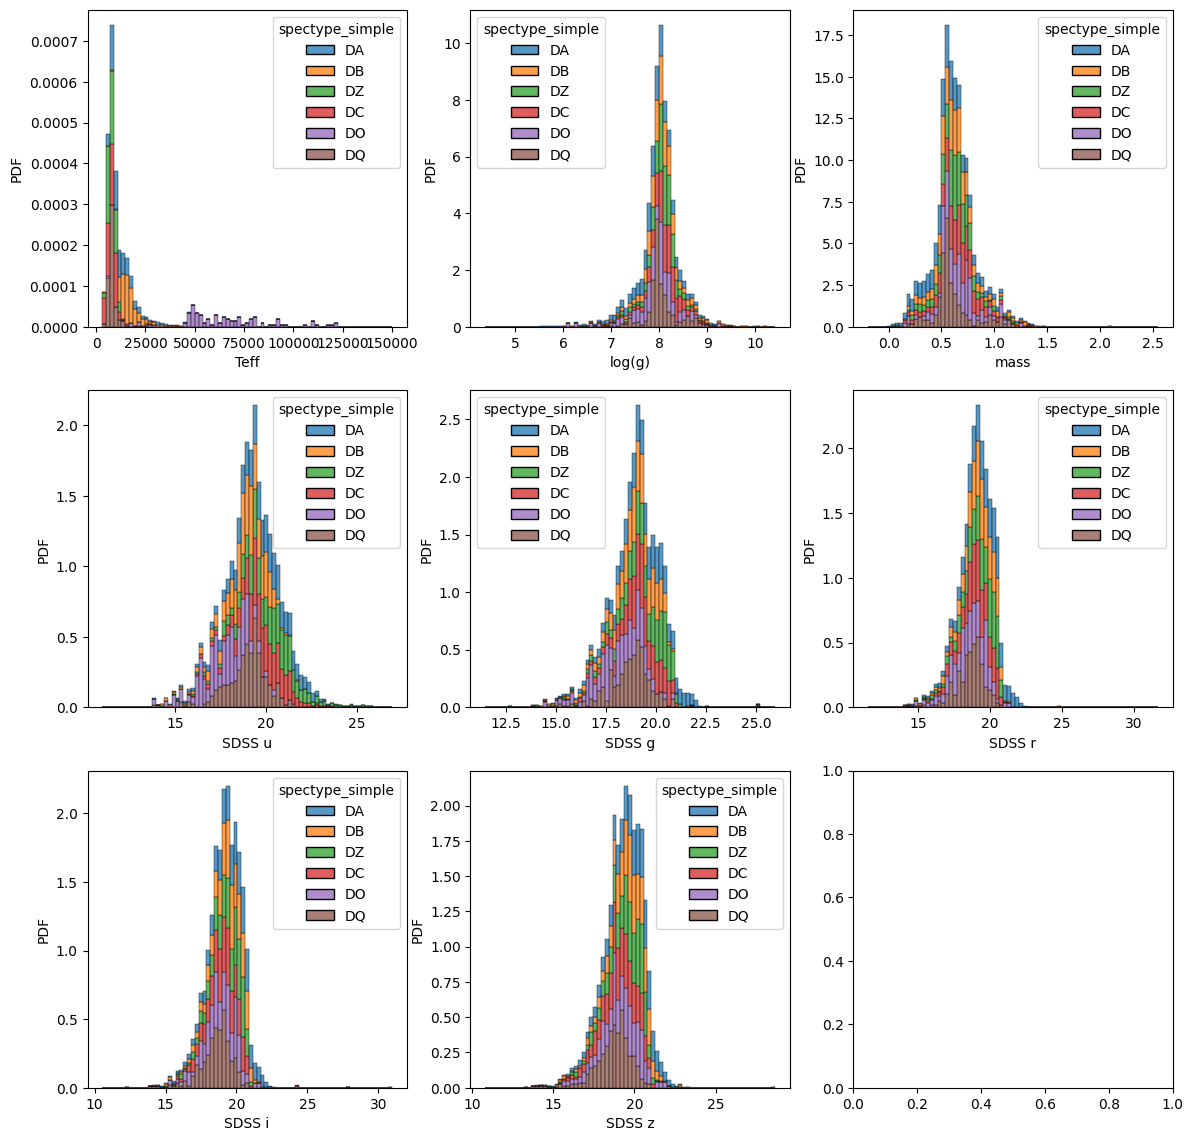

In [12]:
plots = {
    'teff': 'Teff',
    'logg': 'log(g)',
    'mass': 'mass',
    'su': 'SDSS u',
    'sg': 'SDSS g',
    'sr': 'SDSS r',
    'si': 'SDSS i',
    'sz': 'SDSS z',
}

fig, ax = plt.subplots(3, 3, figsize=(14, 14))

for i, key in enumerate(plots):
    _ax = ax.ravel()[i]
    sns.histplot(df, x=key, hue='spectype_simple', bins=75,
                 stat='density', multiple='stack', common_norm=False, ax=_ax)

    _ax.set_xlabel(plots[key])
    _ax.set_ylabel('PDF')

plt.show()

That should be enough preprocessing for now; save this as a .csv for the next notebook:

In [13]:
fn = f'{data_dir}/MWDD-export-preprocessed.csv'
df.to_csv(fn, index=False)

In [14]:
df

,wdid,icrsra,icrsdec,spectype,teff,logg,mass,logL,age,Dpc,...,sg,Dsg,sr,Dsr,si,Dsi,sz,Dsz,EBmV,spectype_simple
0,1RXS J072817.0+273129,07 28 16.72,27 31 19.00,DA,49011.000000,8.000000,0.690000,NaN,NaN,414.38,...,17.01000,0.010000,17.52000,0.010000,17.87000,0.010000,18.25000,0.030000,0.023,DA
1,1RXS J093922.8+264404,09 39 21.82,26 44 01.01,DA,55978.000000,7.820000,0.620000,0.35,0.00150,453.30,...,17.04309,0.004309,17.55377,0.005718,17.95405,0.008747,18.27947,0.027300,0.022,DA
2,1RXS J101340.6+061556,10 13 39.56,06 15 29.61,DA,14375.000000,7.640000,0.437000,NaN,NaN,414.01,...,20.09832,0.017659,20.32519,0.026059,20.57995,0.040973,20.77103,0.174928,0.025,DA
3,1RXS J120428.0+581934,12 04 32.64,58 19 37.03,DA,16786.000000,8.266000,0.779000,NaN,0.21740,440.57,...,19.80970,0.016188,20.08982,0.024771,20.36053,0.044498,20.65621,0.180821,0.020,DA
4,1RXS J132634.4+571052,13 26 29.57,57 11 31.46,DAO,91677.000000,6.600000,0.410000,2.25,0.00010,1790.36,...,18.56828,0.007707,19.12674,0.011760,19.52487,0.019849,19.90997,0.079012,0.019,DA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30683,[VV98b] J093937.9+520146,09 39 37.60,52 01 42.69,DQ,8537.000000,7.970000,0.560000,NaN,0.95000,73.28,...,17.16093,0.004419,17.20979,0.004769,17.32063,0.005603,17.50010,0.013673,0.003,DQ
30684,[VV98c] J223648.2+135539,22 36 48.14,13 55 37.14,DB,17477.000000,7.610000,0.400000,NaN,NaN,575.21,...,20.02853,0.017733,20.29623,0.026535,20.51720,0.043703,20.47960,0.191395,0.059,DB
30685,[YNG2003] 0125-7-5-550-0325,04 44 42.58,00 26 34.82,DAM,6501.000000,8.014000,0.599000,NaN,1.87400,128.74,...,19.61698,0.012845,19.35583,0.013556,19.27045,0.017698,19.32702,0.061503,0.006,DA
30686,[YNG2003] 0125-7-6-555-0301,04 47 58.78,00 58 08.58,DAM,7207.000000,7.779000,0.470000,NaN,1.04300,189.32,...,19.82305,0.014284,19.66508,0.018401,19.65071,0.026416,19.66265,0.090650,0.020,DA
